# Shreyank Shetty (12279686)
## FINM 33150 1 Regression Analysis and Quantitative Trading Strategies
### Homework: Quantile Trading



In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import warnings
import seaborn as sns
import statsmodels.api as sm
import datetime as dt
import requests
import csv
import os
import json 
from datetime import datetime, timedelta
from matplotlib import cm
from scipy.stats import zscore
plt.rcParams["figure.figsize"] = (16,10)
warnings.filterwarnings('ignore')

### Setting Global Variables

In [2]:
apiKey=os.getenv('QuandlKey')
quandl.ApiConfig.api_key = apiKey
#start_date = dt.date(year=2014, month=1, day=1) - pd.DateOffset(months=3)
start_date='2013-01-01'
end_date='2021-01-01'

### Data Gathering 

In [3]:
#function to get entire table using python-requests library 
def getFullTable(table):
    URL = 'https://data.nasdaq.com/api/v3/datatables/ZACKS/'+str(table)+'?&api_key='+apiKey+'&qopts.export=true'
    data = requests.get(URL)
    data= json.loads(data.content.decode("utf-8"))
    link= data['datatable_bulk_download']['file']['link']
    table_df= pd.read_csv(link,compression='zip')
    return table_df

Fethcing the required tables

In [4]:
if not os.path.isfile('zack_mktv.pkl'):
    zack_mt= getFullTable('MT')
    pd.to_pickle(zack_mt, "./zack_mt.pkl")  
    zack_shrs= getFullTable('SHRS')
    pd.to_pickle(zack_shrs, "./zack_shrs.pkl")  
    zack_fc= getFullTable('FC')
    pd.to_pickle(zack_fc, "./zack_fc.pkl")  
    zack_fr= getFullTable('FR')
    pd.to_pickle(zack_fr, "./zack_fr.pkl")  
    zack_mktv= getFullTable('MKTV')
    pd.to_pickle(zack_mktv, "./zack_mktv.pkl")  

else:
    zack_mt= pd.read_pickle("./zack_mt.pkl")
    zack_shrs= pd.read_pickle("./zack_shrs.pkl")
    zack_fc= pd.read_pickle("./zack_fc.pkl")
    zack_fr= pd.read_pickle("./zack_fr.pkl")
    zack_mktv= pd.read_pickle("./zack_mktv.pkl")

### Filtering data for required time frame 

In [5]:
#zack_mt=zack_mt[zack_mt['per_end_date'].between(start_date,end_date)]
zack_shrs=zack_shrs[zack_shrs['per_end_date'].between(start_date,end_date)]
zack_fc=zack_fc[zack_fc['per_end_date'].between(start_date,end_date)]
zack_fr=zack_fr[zack_fr['per_end_date'].between(start_date,end_date)]
zack_mktv=zack_mktv[zack_mktv['per_end_date'].between(start_date,end_date)]


### Applying filter 1: debt to equity of greater than 0.1 

In [6]:
zack_fr= zack_fr[zack_fr['per_end_date'].between(start_date,end_date)]
debtratio_filter = zack_fr[zack_fr['tot_debt_tot_equity']>=0.1]
debtratio_filter = list(debtratio_filter.ticker.unique())
len(debtratio_filter)

8651

### Applying filter 2: US Stocks, not in automotive,financial or insurance sector

In [7]:
sector_filter =zack_mt[(zack_mt.active_ticker_flag == 'Y') & (zack_mt.asset_type == 'COM')& (zack_mt.country_code == 'US')& (~zack_mt.zacks_x_sector_code.isin([np.nan, -9999.0, 13, 5]))]
sector_filter = list(sector_filter.ticker.unique())
len(sector_filter)

4932

### Applying filter 3: end of day adjusted close price available

Taking the intersection of previous two filters to reduce number of tickers that match both filter.

In [8]:
tickers = set(debtratio_filter).intersection(set(sector_filter))
len(tickers)

3052

In [9]:
# Pulling data from quandl in batches since data is too big.

if not os.path.isfile('adj_close.csv'):

    tlen=int(len(tickers)/6)
    part1 = quandl.get_table('QUOTEMEDIA/PRICES',ticker=list(tickers)[:tlen],
                    qopts={"columns":["ticker","date","adj_close"]}, date={'gte':'2013-01-01','lte': '2021-01-01'}, paginate=True)

    part2= quandl.get_table('QUOTEMEDIA/PRICES',ticker=list(tickers)[tlen:tlen*2],
                qopts={"columns":["ticker","date","adj_close"]}, date={'gte':'2013-01-01','lte': '2021-01-01'}, paginate=True)

    part3= quandl.get_table('QUOTEMEDIA/PRICES',ticker=list(tickers)[tlen*2:tlen*3],
                qopts={"columns":["ticker","date", "adj_close"]}, date={'gte':'2013-01-01','lte': '2021-01-01'}, paginate=True)

    part4= quandl.get_table('QUOTEMEDIA/PRICES',ticker=list(tickers)[tlen*3:tlen*4],
                qopts={"columns":["ticker","date", "adj_close"]}, date={'gte':'2013-01-01','lte': '2021-01-01'}, paginate=True)

    part5= quandl.get_table('QUOTEMEDIA/PRICES',ticker=list(tickers)[tlen*4:tlen*5],
                qopts={"columns":["ticker","date", "adj_close"]}, date={'gte':'2013-01-01','lte': '2021-01-01'}, paginate=True)

    part6= quandl.get_table('QUOTEMEDIA/PRICES',ticker=list(tickers)[tlen*5:tlen*6],
                qopts={"columns":["ticker","date", "adj_close"]}, date={'gte':'2013-01-01','lte': '2021-01-01'}, paginate=True)

    tot = pd.concat([part1, part2, part3, part4, part5, part6], axis=0)

    tot.to_csv('adj_close.csv')
    
else:
    tot=pd.read_csv('adj_close.csv')

#### Filtering only those tickers that have traded for the most in the given timeframe. 

In [10]:
max1= tot.groupby('ticker').count().max().values[0]
counted = tot.groupby('ticker').count()
tics=list(counted[counted["date"]==max1].index) # total list of tickers that match the filters 

In [11]:
len(tics)

1412

## Calculating the financial ratios 

In [12]:
SHRS= zack_shrs[zack_shrs['ticker'].isin(tics)]
FC=zack_fc[zack_fc['ticker'].isin(tics)]
MKTV=zack_mktv[zack_mktv['ticker'].isin(tics)]
FR=zack_fr[zack_fr['ticker'].isin(tics)]
TOT=tot[tot['ticker'].isin(tics)]

# merge all the fundamental data
fundamentals = MKTV[['ticker', 'per_end_date', 'mkt_val']].merge(SHRS[['ticker', 'per_end_date', 'shares_out']],how ='outer')\
.merge(FR[['ticker', 'per_end_date','tot_debt_tot_equity','ret_invst']],how ='outer')\
.merge(FC[['ticker', 'per_end_date','filing_date','net_lterm_debt', 'tot_lterm_debt', 'eps_diluted_net', 'basic_net_eps']],how= 'outer')\
.sort_values(by=['ticker', 'per_end_date']).dropna()

#change the date columns to datetime objects
fundamentals[['per_end_date','filing_date']]=fundamentals[['filing_date','per_end_date']].apply(pd.to_datetime)
TOT[['date']]=TOT[['date']].apply(pd.to_datetime)

#merge eod data to fundamental data
fundamentals['net_lterm_debt'] = np.where(fundamentals.net_lterm_debt.isna(),fundamentals.tot_lterm_debt,fundamentals.net_lterm_debt)
fundamentals = fundamentals.rename(columns={'filing_date':'date'})
data =TOT.merge(fundamentals, how="left").sort_values(by=['ticker', 'date'])
#data = data.iloc[: , 1:]

#generate a single datframe to combine all. Managing the quaterly data and daily using forward fill and merge again at the end.
data[fundamentals.columns.drop(['ticker','date','per_end_date'])] = data[fundamentals.columns.drop(['ticker','date','per_end_date'])].shift(1)
data =data.fillna(method="ffill")
uniquedatelist = list(data['date'].unique())
data['per_end_date'] =  np.where(np.isin(data.per_end_date.values, uniquedatelist),data.per_end_date, data.per_end_date - timedelta(days=2))
prev_price = data[['ticker','date','adj_close']].rename(columns={'adj_close':'prevqt_price'})
data = data.merge(prev_price,how ='left', left_on=['ticker', 'per_end_date'], right_on=['ticker', 'date']).set_index('ticker').rename(columns={'date_x':'date'}).drop(['date_y'],axis=1)

data = data[data['date']>='2014-01-01']

#Generating the financiaratios
data['debt_to_mktcap'] = (data.tot_debt_tot_equity*data.prevqt_price)/data.adj_close
data['ret_on_int'] = (data.ret_invst*(data.mkt_val+data.net_lterm_debt))/((data.mkt_val*data.adj_close/data.prevqt_price)+data.net_lterm_debt)
data['price_to_earnings'] = data.adj_close/data.eps_diluted_net
data['price_to_earnings'] = np.where(data.price_to_earnings<=0,0.001,data.price_to_earnings) 
finaldata=data
finaldata

,date,adj_close,per_end_date,mkt_val,shares_out,tot_debt_tot_equity,ret_invst,net_lterm_debt,tot_lterm_debt,eps_diluted_net,basic_net_eps,prevqt_price,debt_to_mktcap,ret_on_int,price_to_earnings
ticker,,,,,,,,,,,,,,,
A,2014-01-02,37.848092,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A,2014-01-03,38.326159,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A,2014-01-06,38.137626,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A,2014-01-07,38.683026,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A,2014-01-08,39.315960,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZWS,2020-12-24,38.990873,2020-07-28,3502.05,120.14,0.9045,1.431,74.4,1148.0,0.29,0.3,29.702346,0.689027,1.095532,134.451285
ZWS,2020-12-28,39.338739,2020-07-28,3502.05,120.14,0.9045,1.431,74.4,1148.0,0.29,0.3,29.702346,0.682934,1.085997,135.650825
ZWS,2020-12-29,38.662884,2020-07-28,3502.05,120.14,0.9045,1.431,74.4,1148.0,0.29,0.3,29.702346,0.694872,1.104676,133.320290


In [13]:
def getRank(data, method = ['simple', 'z-score'], by = None, relpos = False):
    
    col_names = np.array(data.columns)
    
    if by is None:
        by = col_names[1:]
    
    if method == 'simple':
        return data.sort_values(by, ascending = relpos)
        
    if method == 'z-score':
        temp = data.loc[:,by].apply(zscore)
        sum_zscores = temp.sum(axis=1, min_count=1)
        data['total_zscore'] = sum_zscores
        return data.sort_values('total_zscore', ascending = relpos)

In [38]:
finaldata['year_month'] = finaldata['date'].dt.strftime('%Y-%m')
start_t = list(finaldata[['date','year_month']].reset_index().groupby(['ticker','year_month'])['date'].min().unique())
end_t = list(finaldata[['date','year_month']].reset_index().groupby(['ticker','year_month'])['date'].max().unique())
signaldays = np.sort(start_t + end_t)
trade_months = finaldata.year_month.unique()


In [44]:
def quantile_strategy(tradedcp =100000, lossscal = 1, rf = 0, data =None, method =None, by =None, relpos=False, decile= 0.1):
    
    
    ratiotable = finaldata[['price_to_earnings', 'ret_on_int', 'debt_to_mktcap', 'date']]
    ratiotable = ratiotable[ratiotable.date.isin(start_t)].reset_index().set_index('date')
    pricetable = finaldata[['date', 'adj_close']].reset_index().set_index('date')
    
    strat_realized = None
    strat_unrealized = None

    traded_cap = tradedcp
    lossscalar = lossscal
    K = traded_cap*10
    rf = rf
    
    for i in trade_months:
        ranked_data = getRank(ratiotable.loc[i].reset_index(drop = True), method= method, by = by, relpos = True)
        decileCutoff = int(200*decile)
        longtrade = pricetable[pricetable.ticker.isin(ranked_data.ticker[:decileCutoff])].loc[i].reset_index().drop_duplicates().set_index(['date','ticker']).unstack().sum(axis=1)
        longshares = traded_cap/longtrade[0]
        longtrade = longtrade*longshares

        shorttrade = pricetable[pricetable.ticker.isin(ranked_data.ticker[:-decileCutoff])].loc[i].reset_index().drop_duplicates().set_index(['date','ticker']).unstack().sum(axis=1)
        shortshares = traded_cap/shorttrade[0]
        shorttrade = shorttrade*shortshares
        shorttrade[0] = shorttrade[0]*(1-rf)
        
        unreltemp = pd.DataFrame({'Long Positions': longtrade, 'Short Positions': shorttrade})
        unreltemp['nettrade'] = longtrade-shorttrade
        reltemp = unreltemp[unreltemp.index.isin(signaldays)]
        unreltemp['pnl'] = unreltemp['nettrade'].diff()
        reltemp['pnl'] = reltemp['nettrade'].diff()
        
        
        if reltemp.pnl[1]<0:
            traded_cap = traded_cap * lossscalar
        else:
            traded_cap = tradedcp

        if strat_unrealized is None:
            strat_unrealized = unreltemp
            strat_realized = reltemp
            
        else:
            strat_unrealized = pd.concat([strat_unrealized, unreltemp])
            strat_realized = pd.concat([strat_realized, reltemp])
            
    strat_unrealized['cum_pnl'] = strat_unrealized['pnl'].cumsum()
    strat_realized['cum_pnl'] = strat_realized['pnl'].cumsum()
    strat_realized['return'] = strat_realized['pnl']/K
    return strat_realized, strat_unrealized  

### Performance of Price to Earnings Ratios

In [49]:
pe= quantile_strategy(tradedcp =100000, lossscal = 2, rf = 0, data =finaldata, method ='simple', by =['price_to_earnings'], relpos=False, decile= 0.1)
unrealized_pnl=pe[1][['pnl','cum_pnl']]
realized_pnl=pe[0][['pnl','cum_pnl','return']]

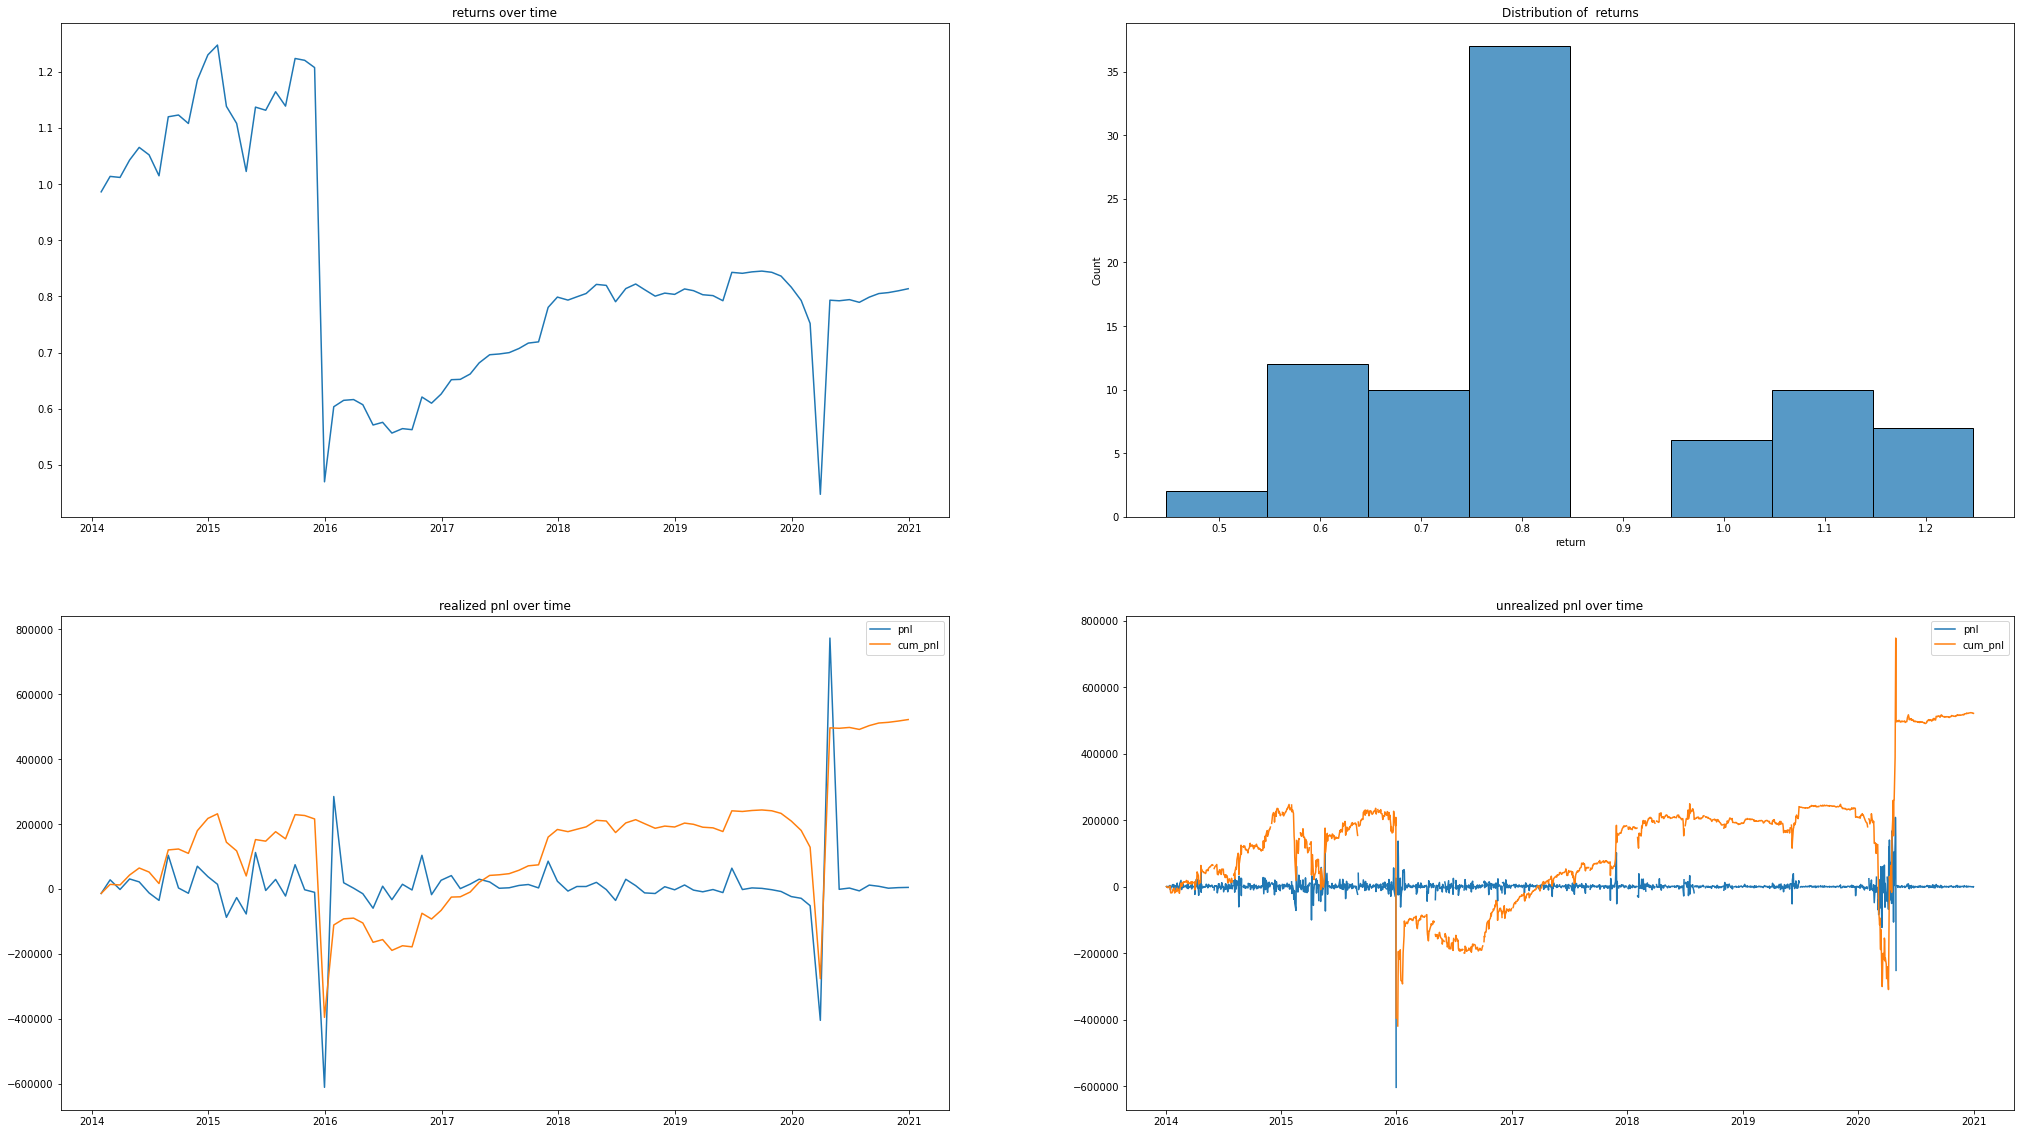

In [69]:
returns = (1 + realized_pnl['return'].dropna()).cumprod()
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(35,20))
ax[0][0].plot(returns)
ax[0][0].set_title("returns over time")

sns.histplot(returns,ax=ax[0][1])
ax[0][1].set_title("Distribution of  returns")

real_pnl=realized_pnl[['pnl','cum_pnl']]
#fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(35,10))
ax[1][0].plot(real_pnl.dropna())
ax[1][0].set_title("realized pnl over time")
ax[1][0].legend(real_pnl.columns)

ax[1][1].plot(unrealized_pnl)
ax[1][1].set_title("unrealized pnl over time")
ax[1][1].legend(unrealized_pnl.columns)

### Performance of return on investment ratio 

In [77]:
pe= quantile_strategy(tradedcp =100000, lossscal = 2, rf = 0, data =finaldata, method ='simple', by =['ret_on_int'], relpos=True, decile= 0.1)
unrealized_pnl=pe[1][['pnl','cum_pnl']]
realized_pnl=pe[0][['pnl','cum_pnl','return']]

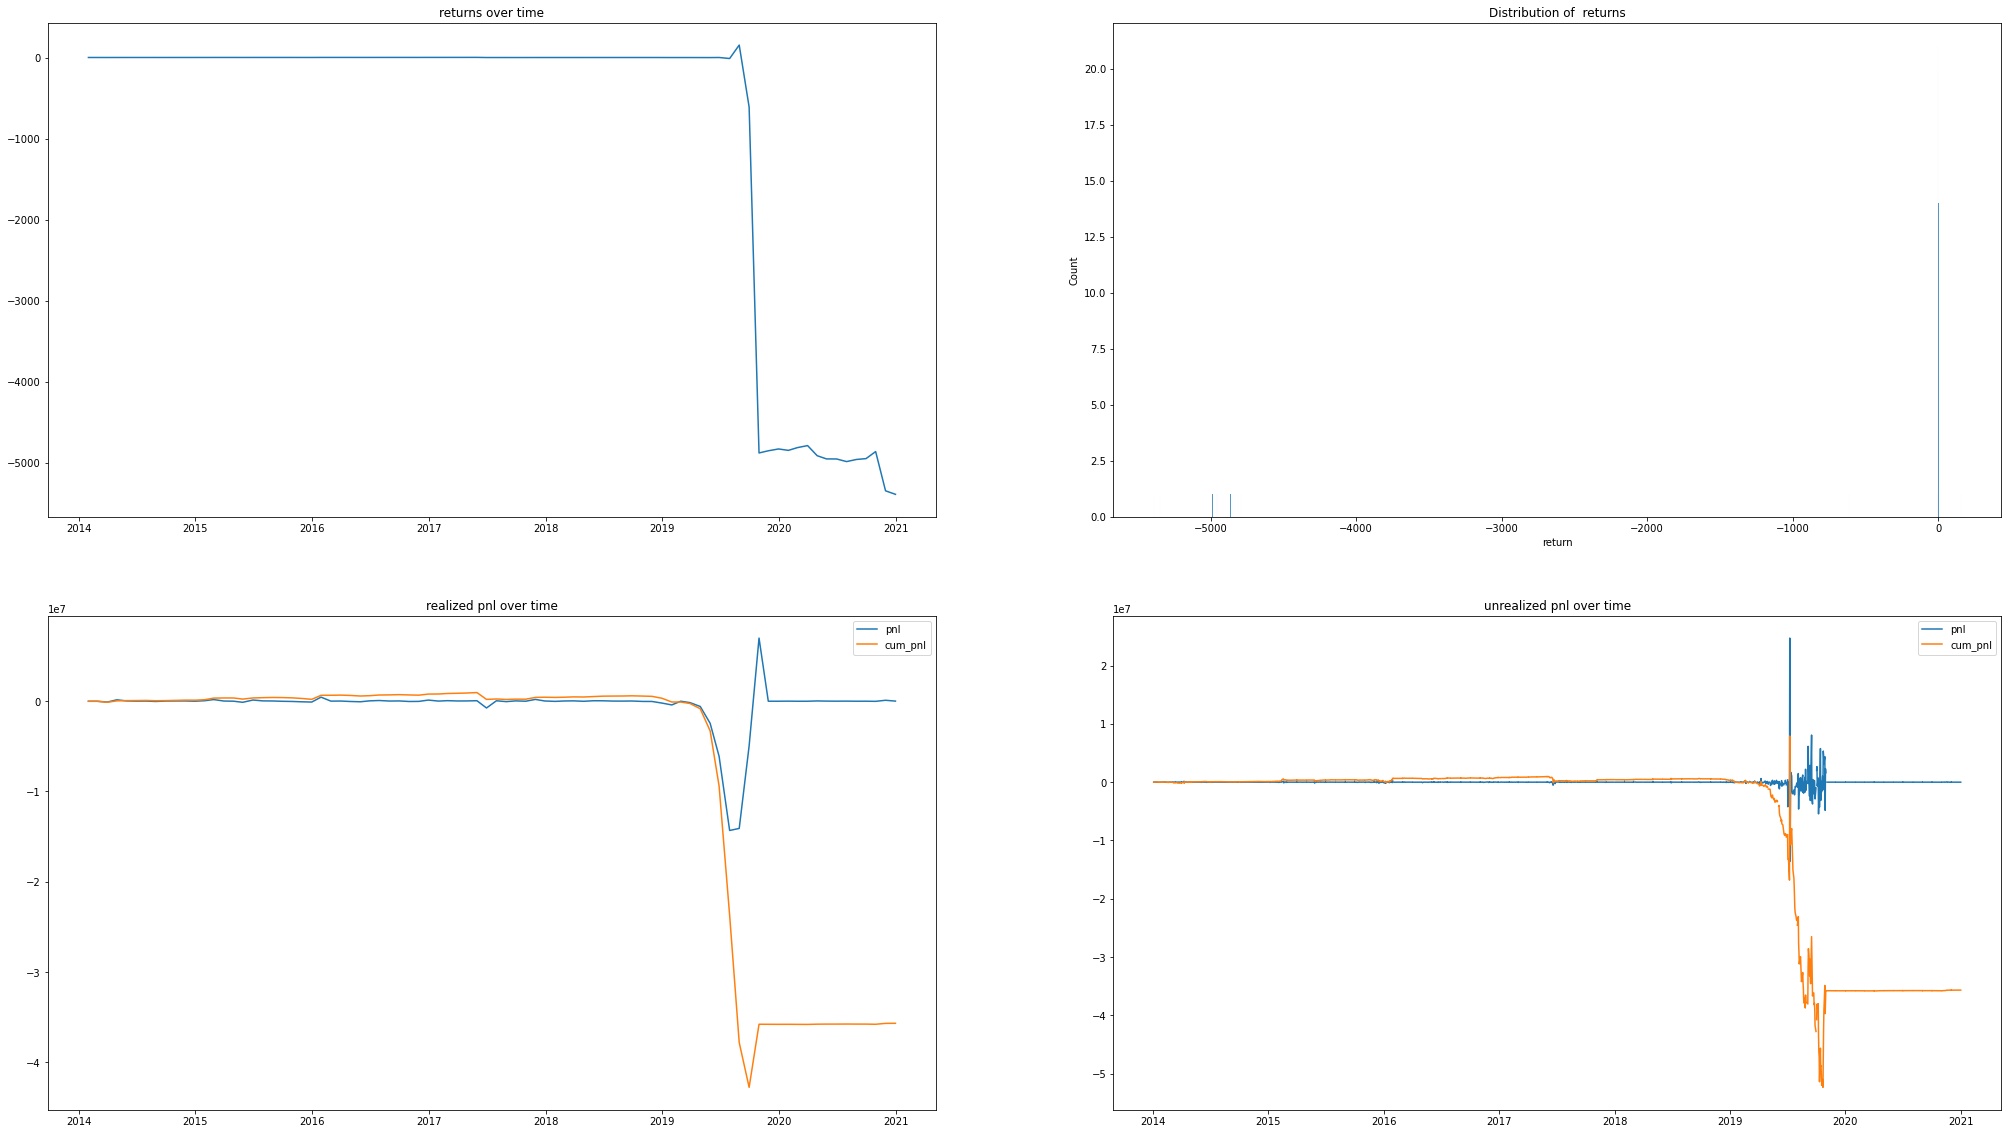

In [78]:
returns = (1 + realized_pnl['return'].dropna()).cumprod()
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(35,20))
ax[0][0].plot(returns)
ax[0][0].set_title("returns over time")

sns.histplot(returns,ax=ax[0][1])
ax[0][1].set_title("Distribution of  returns")

real_pnl=realized_pnl[['pnl','cum_pnl']]
#fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(35,10))
ax[1][0].plot(real_pnl.dropna())
ax[1][0].set_title("realized pnl over time")
ax[1][0].legend(real_pnl.columns)

ax[1][1].plot(unrealized_pnl)
ax[1][1].set_title("unrealized pnl over time")
ax[1][1].legend(unrealized_pnl.columns)

### Performance of Debt to Marketcap ratio

In [72]:
pe= quantile_strategy(tradedcp =100000, lossscal = 2, rf = 0, data =finaldata, method ='simple', by =['debt_to_mktcap'], relpos=False, decile= 0.05)
unrealized_pnl=pe[1][['pnl','cum_pnl']]
realized_pnl=pe[0][['pnl','cum_pnl','return']]

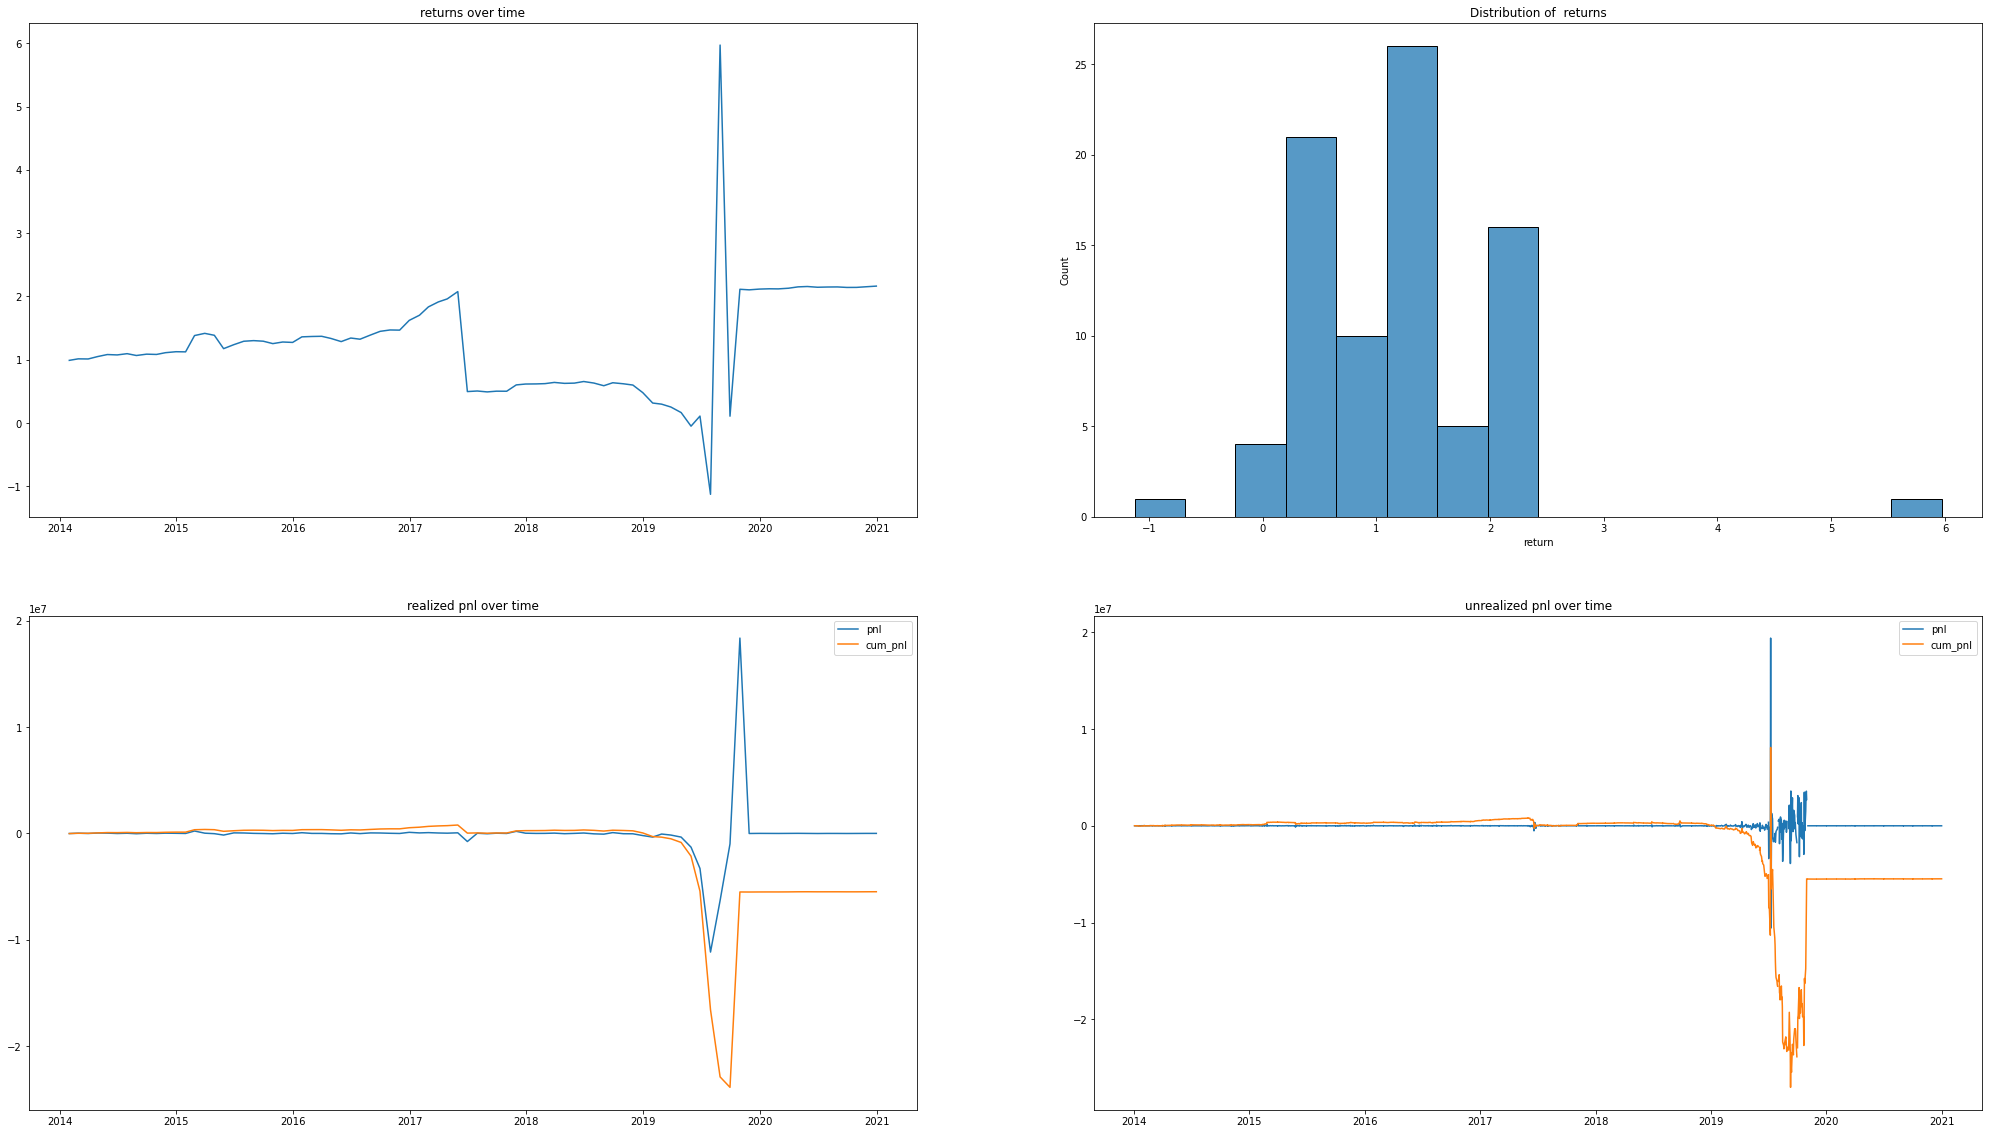

In [73]:
returns = (1 + realized_pnl['return'].dropna()).cumprod()
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(35,20))
ax[0][0].plot(returns)
ax[0][0].set_title("returns over time")

sns.histplot(returns,ax=ax[0][1])
ax[0][1].set_title("Distribution of  returns")

real_pnl=realized_pnl[['pnl','cum_pnl']]
#fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(35,10))
ax[1][0].plot(real_pnl.dropna())
ax[1][0].set_title("realized pnl over time")
ax[1][0].legend(real_pnl.columns)

ax[1][1].plot(unrealized_pnl)
ax[1][1].set_title("unrealized pnl over time")
ax[1][1].legend(unrealized_pnl.columns)

### Performance of Combination by summing up the z-scores

In [79]:
pe= quantile_strategy(tradedcp =100000, lossscal = 2, rf = 0, data =finaldata, method ='z-score', by =['ret_on_int','price_to_earnings','debt_to_mktcap'], relpos=True, decile= 0.1)
unrealized_pnl=pe[1][['pnl','cum_pnl']]
realized_pnl=pe[0][['pnl','cum_pnl','return']]

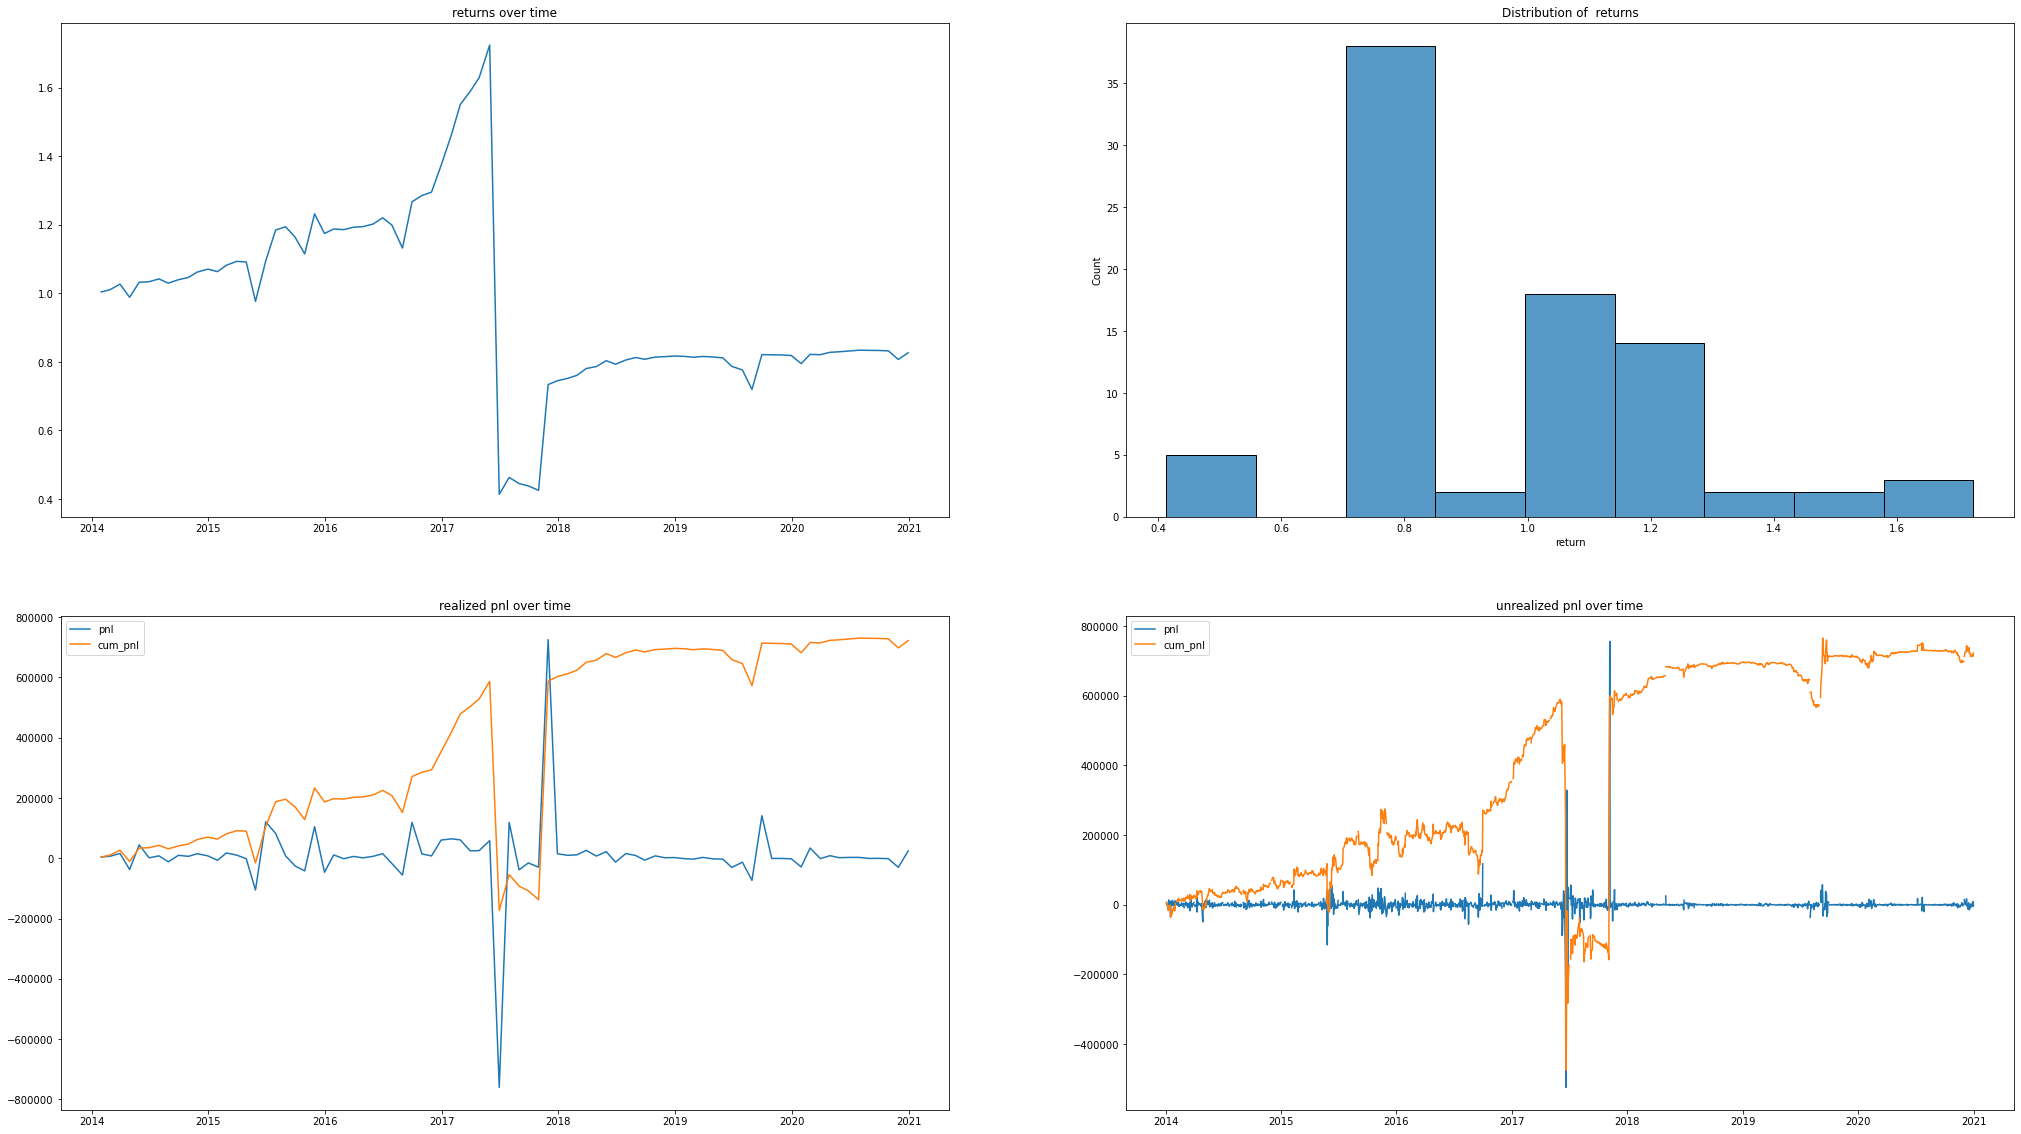

In [80]:
returns = (1 + realized_pnl['return'].dropna()).cumprod()
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(35,20))
ax[0][0].plot(returns)
ax[0][0].set_title("returns over time")

sns.histplot(returns,ax=ax[0][1])
ax[0][1].set_title("Distribution of  returns")

real_pnl=realized_pnl[['pnl','cum_pnl']]
#fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(35,10))
ax[1][0].plot(real_pnl.dropna())
ax[1][0].set_title("realized pnl over time")
ax[1][0].legend(real_pnl.columns)

ax[1][1].plot(unrealized_pnl)
ax[1][1].set_title("unrealized pnl over time")
ax[1][1].legend(unrealized_pnl.columns)

### Analysis with Fama French Model 

In [84]:
fama_french= pd.read_csv('/Users/shreyankshetty/Documents/QuantTradingStrats/week2/F-F_Research_Data_Factors_daily.csv')
fama_french.drop(fama_french.tail(1).index,inplace=True)
fama_french['date'] = pd.to_datetime(fama_french['date'])
fama_french.set_index('date', inplace=True)
fama_french=fama_french[start_date:end_date]


#optimal_strat_df['Portfolio_ret'] = returns['Portfolio_value'].pct_change(periods=1).dropna()

fama_french["myportfolio"]= returns

fama_french = fama_french.dropna()

Y = fama_french["myportfolio"]
X = sm.add_constant(fama_french[["Mkt-RF","SMB","HML","RF"]])

In [87]:
fama_french.cov()

,Mkt-RF,SMB,HML,RF,myportfolio
Mkt-RF,0.683077,0.053535,-0.071829,0.000138,-0.012367
SMB,0.053535,0.350005,0.009395,0.000212,0.011599
HML,-0.071829,0.009395,0.476447,-0.000367,0.031833
RF,0.000138,0.000212,-0.000367,0.000012,-0.000441
myportfolio,-0.012367,0.011599,0.031833,-0.000441,0.068538


MIN Correlation pair is ('myportfolio', 'RF')
MAX Correlation pair is ('myportfolio', 'myportfolio')


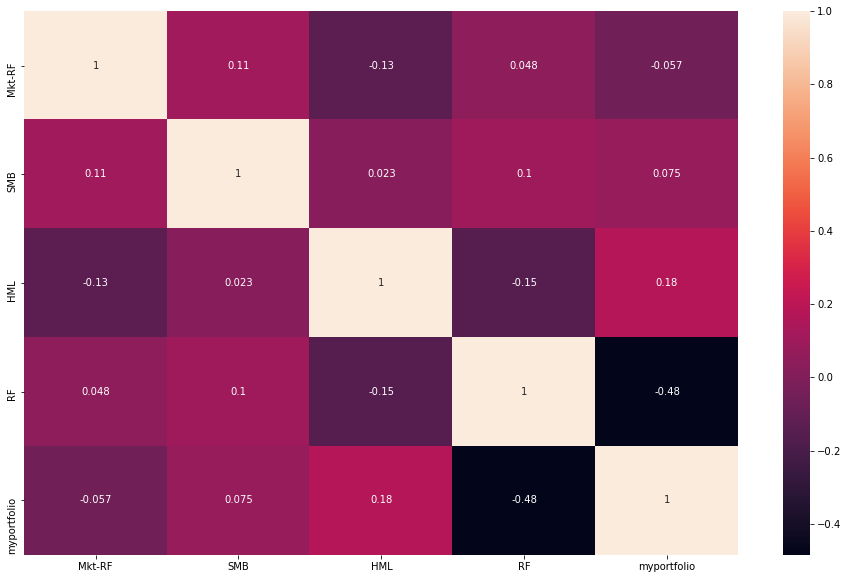

In [89]:
def display_corr(df, print_maxmin=True):
    
    corr = df.corr()
    sns.heatmap(corr, annot=True)

    if print_maxmin:
        corr_rank = corr.unstack().sort_values().dropna()
        pair_max = corr_rank.index[-1]
        pair_min = corr_rank.index[0]

        print(f'MIN Correlation pair is {pair_min}')
        print(f'MAX Correlation pair is {pair_max}')

display_corr(fama_french)

In [85]:
reg_results = sm.OLS(Y,X).fit()
reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            myportfolio   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     6.983
Date:                Sat, 05 Feb 2022   Prob (F-statistic):           7.25e-05
Time:                        18:53:51   Log-Likelihood:                 6.6031
No. Observations:                  84   AIC:                            -3.206
Df Residuals:                      79   BIC:                             8.948
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0867      0.034     31.881      0.000       1.019       1.155
Mkt-RF        -0.0114      0.031     -0.366      0.715      -0.073       0.050
SMB            0.0558      0.043      1.289      0.201      -0.030       0.142
HML            0.0361      0.037      0.964      0.338      -0.038       0.111
RF           -36.2442      7.418     -4.886      0.000     -51.009     -21.480
==============================================================================
Omnibus:                       15.039   Durbin-Watson:                   0.553
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               30.588
Skew:                           0.596   Prob(JB):                     2.28e-07
Kurtosis:                       5.705   Cond. No.                         302.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Conclusion of the trading strategy 

- This strategy is suspectible to large changes as evident by the graphs, showing large swings for a particular dates 
- The startegy provides divirsification benefits as seen from the low r-squared to the fama-french factors. It also has low correlation to the fama french factors
- The returns from this strategy is poor and does not beat the market over the trading period
- Further filtering the universe of stocks and reducing them, should imporve the returns further 

#### Next Steps/ Further imporvements : 